In [1]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'tesla-stock-price:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1007%2F1814%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240208%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240208T120615Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D948344eba0bb9f64d12cd1557001d79999ae676a5c4cc81b4c8a8e6b542b11da8903bf8142ea72c0992700f75d6b147ec0b033c1634b8c31e8f60d693470821e482fed36a30da5d23c10423d85bc96c41bdcdf85a5763b72bb55544d4ce572ecd5c4da128b0386299561af4b9413cf4a2a70a7f27d0aa57596cdda768e8cd8fc64cb82ce906a82691ba3802ee06f6c63837188f1535e6b232a73496964ce8b78f3850a6e6aaf978b096cc5c4f9d87dde50fb729ed7fcf9a093dd2efe42cd231ca355c3cc7c25ec6914b9206c5c5c5fea9d732df2d2fac4ab1062d5b2c8234dac2e6e49ef7e285c5f3e42f66d993507f7c0da50fe772b89ab2a12a11c27b5dff4,sandp500:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1908%2F17155%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240208%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240208T120615Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D56ef3dfa7c3823db28f45bb3cb738f75846a8f5bac044af45ca5a3c37dcda5d30b13eb99d157bd1cae2620472d12325dd7a6547f8f136a5f760303aeee3f5e78cf89dcbb797f905fb2a6d3d2d02222acc2f1fc6e9120930765605174f2c9c1a6f4c3fdbc13b86784362cbd9887d9008d333247faef2828de8a292d7d12e9fa981223aeb0fed4d1075630e5985a7bb669b41a311ec5b00b61be1b7b41051ca04140def149b75c8443051b8949eaaffa594a65789deb2fdf62320856065ba04a57f26d56fa6563a0468e64d95af7f453be3ad74a34ef28af7f70e5e8b8d256f83b0087e61f3c553989d2f407267ed04895b77991aeb9de2d215444990c095bfa8b,amzn-dpz-btc-ntfx-adjusted-may-2013may2019:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F195545%2F433077%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240208%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240208T120615Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D857b2c2c8a50d659d4a6eb4c45b420cf1772f0857d8d44562225674435a2992f9d5360df629dd661060d0de889670fbf79782cb9519148b71b1c8713da90cd32bb49f93fbc1ad50ccac61b891892dd98315ce604f064b9c9f2d33dffb3b720898a15aa5544509efbf6c9fb71981280cbed544bb8aec7c1b5e8e65d8a5358168b806be4d6f58732841a1c259550326d970cf66e20c65185bb3f56f3e7e2ca16f3cb7314a28ed63b9380f8953201111fc9a550fc7c19104461a90585c9d12e136d6cf50302ab47b0496260e63433f64c7186a3daa25d777f8055d5238be694f06a73d18e602dc6f09463a6987f2a78e5cf3486a5a519d7b23266d7f20cacb29dfe,apple-aapl-historical-stock-data:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F533900%2F976925%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240208%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240208T120615Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D8094d0562a3320f847cc79e967ae9d48c5413883a36dbf9975ab2e05ce40a01725eda874e1c52bdb963d33bfdce77e4c62a6e442716d91a57a4d75d14a1838650c7f79ef766a81b3a151897b22d83fbed71bd349aba0ade932d8fd3f5ae8974debbed2022c4ca068b48a1283281dc3bf10a8c91ab8f8dbab9ecab18dfe35e834c4014961acee20d9b17cc1e40c17cb2a4cedd9934c699cbccda9ae584a53d11d75a0cd2fd3bb1341e6ac5072ae21e1495155aedee883b47ad77c0ddd9495fba552d71d7a9b4ffb272a9eabdc322c5d541ad110942e4b52c0b20aa813735f6063a99c724e9d4ec1ad4a1367e8149ce2fe9af0beae92a17d6dd6dfe08dd701450c'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 34499 bytes downloaded
Downloaded and uncompressed: tesla-stock-price
[==================================================] 20283917 bytes downloaded
Downloaded and uncompressed: sandp500
[==================================================] 30437 bytes downloaded
Downloaded and uncompressed: amzn-dpz-btc-ntfx-adjusted-may-2013may2019
[==================================================] 50651 bytes downloaded
Downloaded and uncompressed: apple-aapl-historical-stock-data
Data source import complete.


In [2]:
!pip install -q yfinance

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

# For reading stock data from yahoo
from pandas_datareader.data import DataReader
import yfinance as yf
from pandas_datareader import data as pdr

yf.pdr_override()

# For time stamps
from datetime import datetime


# The tech stocks we'll use for this analysis
tech_list = ['AAPL', 'GOOG', 'MSFT', 'AMZN']

# Set up End and Start times for data grab
tech_list = ['AAPL', 'GOOG', 'MSFT', 'AMZN']

end = datetime.now()
start = datetime(end.year - 1, end.month, end.day)

for stock in tech_list:
    globals()[stock] = yf.download(stock, start, end)


company_list = [AAPL, GOOG, MSFT, AMZN]
company_name = ["APPLE", "GOOGLE", "MICROSOFT", "AMAZON"]

for company, com_name in zip(company_list, company_name):
    company["company_name"] = com_name

df = pd.concat(company_list, axis=0)
df.tail(10)

/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,company_name
Date,,,,,,,
2024-01-25,156.949997,158.509995,154.550003,157.750000,157.750000,43638600,AMAZON
2024-01-26,158.419998,160.720001,157.910004,159.119995,159.119995,51047400,AMAZON
2024-01-29,159.339996,161.289993,158.899994,161.259995,161.259995,45270400,AMAZON
2024-01-30,160.699997,161.729996,158.490005,159.000000,159.000000,45207400,AMAZON
2024-01-31,157.000000,159.009995,154.809998,155.199997,155.199997,50284400,AMAZON
2024-02-01,155.869995,159.759995,155.619995,159.279999,159.279999,76542400,AMAZON
2024-02-02,169.190002,172.500000,167.330002,171.809998,171.809998,117154900,AMAZON
2024-02-05,170.199997,170.550003,167.699997,170.309998,170.309998,55081300,AMAZON
2024-02-06,169.389999,170.710007,167.649994,169.149994,169.149994,42505500,AMAZON


We have only 255 records in one year because weekends are not included in the data.

In [5]:
# Summary Stats
AAPL.describe()

,Open,High,Low,Close,Adj Close,Volume
count,251.000000,251.000000,251.000000,251.000000,251.000000,2.510000e+02
mean,177.237371,178.758247,175.953665,177.473506,177.124225,5.728386e+07
std,13.518221,13.380937,13.465797,13.410318,13.570668,1.582289e+07
min,144.380005,146.710007,143.899994,145.309998,144.722931,2.404830e+07
25%,169.794998,171.275002,168.269997,170.359993,170.135841,4.726110e+07
50%,178.350006,180.119995,177.130005,178.720001,178.375000,5.376350e+07
75%,189.209999,189.985001,187.605003,189.334999,189.147972,6.344460e+07
max,198.020004,199.619995,197.000000,198.110001,198.110001,1.282567e+08


In [6]:
# General info
AAPL.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 251 entries, 2023-02-08 to 2024-02-07
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          251 non-null    float64
 1   High          251 non-null    float64
 2   Low           251 non-null    float64
 3   Close         251 non-null    float64
 4   Adj Close     251 non-null    float64
 5   Volume        251 non-null    int64  
 6   company_name  251 non-null    object 
dtypes: float64(5), int64(1), object(1)
memory usage: 15.7+ KB


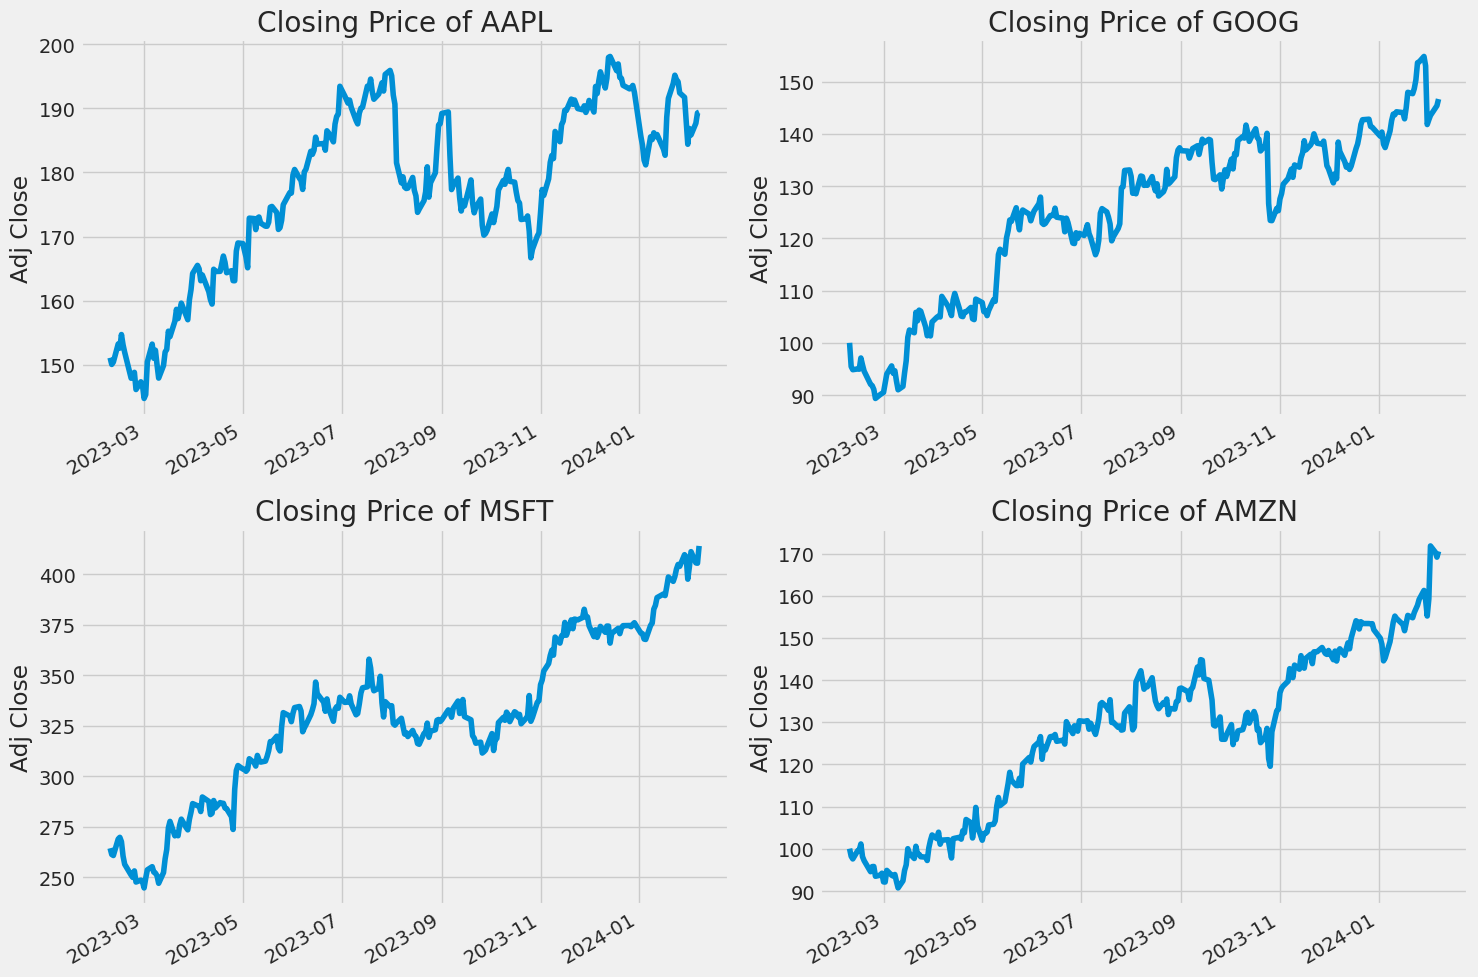

In [7]:
# Let's see a historical view of the closing price
plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, company in enumerate(company_list, 1):
    plt.subplot(2, 2, i)
    company['Adj Close'].plot()
    plt.ylabel('Adj Close')
    plt.xlabel(None)
    plt.title(f"Closing Price of {tech_list[i - 1]}")

plt.tight_layout()

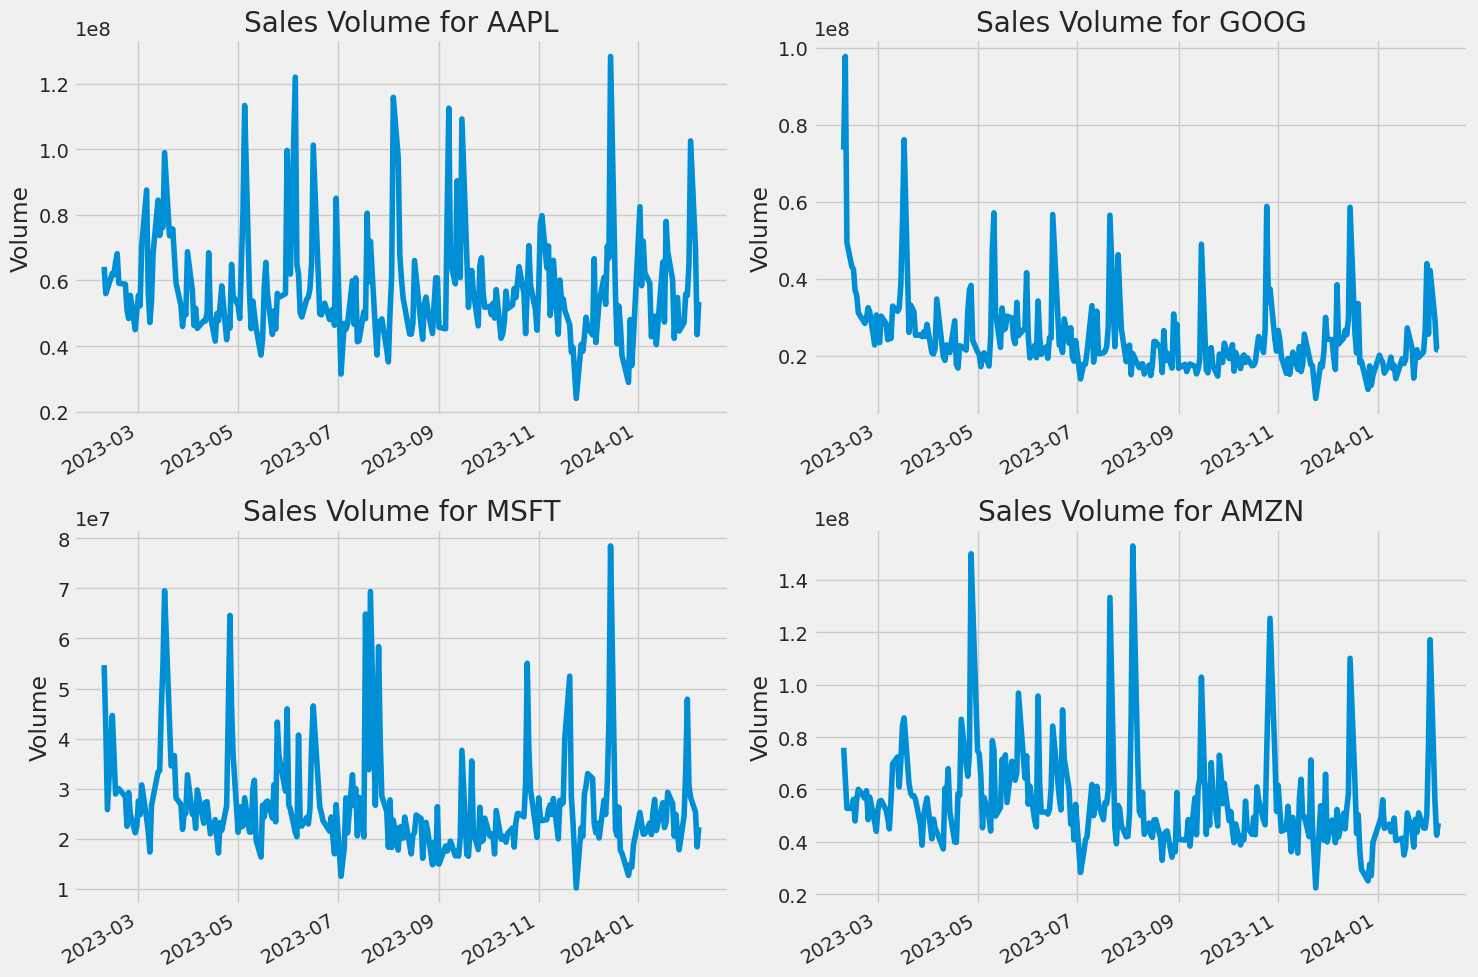

In [8]:
# Now let's plot the total volume of stock being traded each day
plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, company in enumerate(company_list, 1):
    plt.subplot(2, 2, i)
    company['Volume'].plot()
    plt.ylabel('Volume')
    plt.xlabel(None)
    plt.title(f"Sales Volume for {tech_list[i - 1]}")

plt.tight_layout()

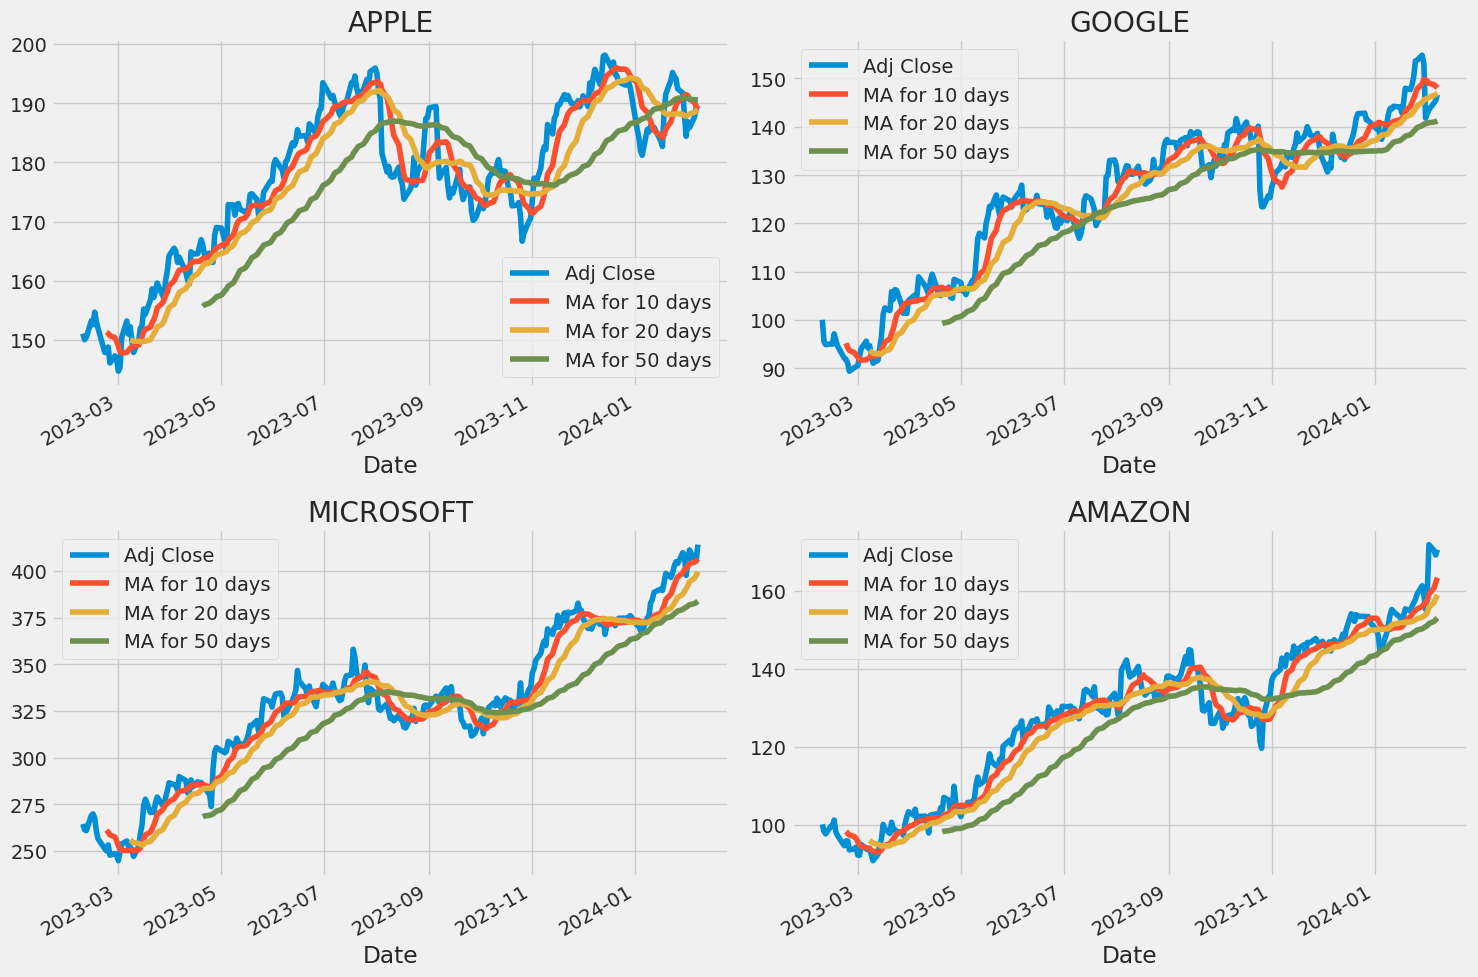

In [9]:
ma_day = [10, 20, 50]

for ma in ma_day:
    for company in company_list:
        column_name = f"MA for {ma} days"
        company[column_name] = company['Adj Close'].rolling(ma).mean()


fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(10)
fig.set_figwidth(15)

AAPL[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[0,0])
axes[0,0].set_title('APPLE')

GOOG[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[0,1])
axes[0,1].set_title('GOOGLE')

MSFT[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[1,0])
axes[1,0].set_title('MICROSOFT')

AMZN[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[1,1])
axes[1,1].set_title('AMAZON')

fig.tight_layout()

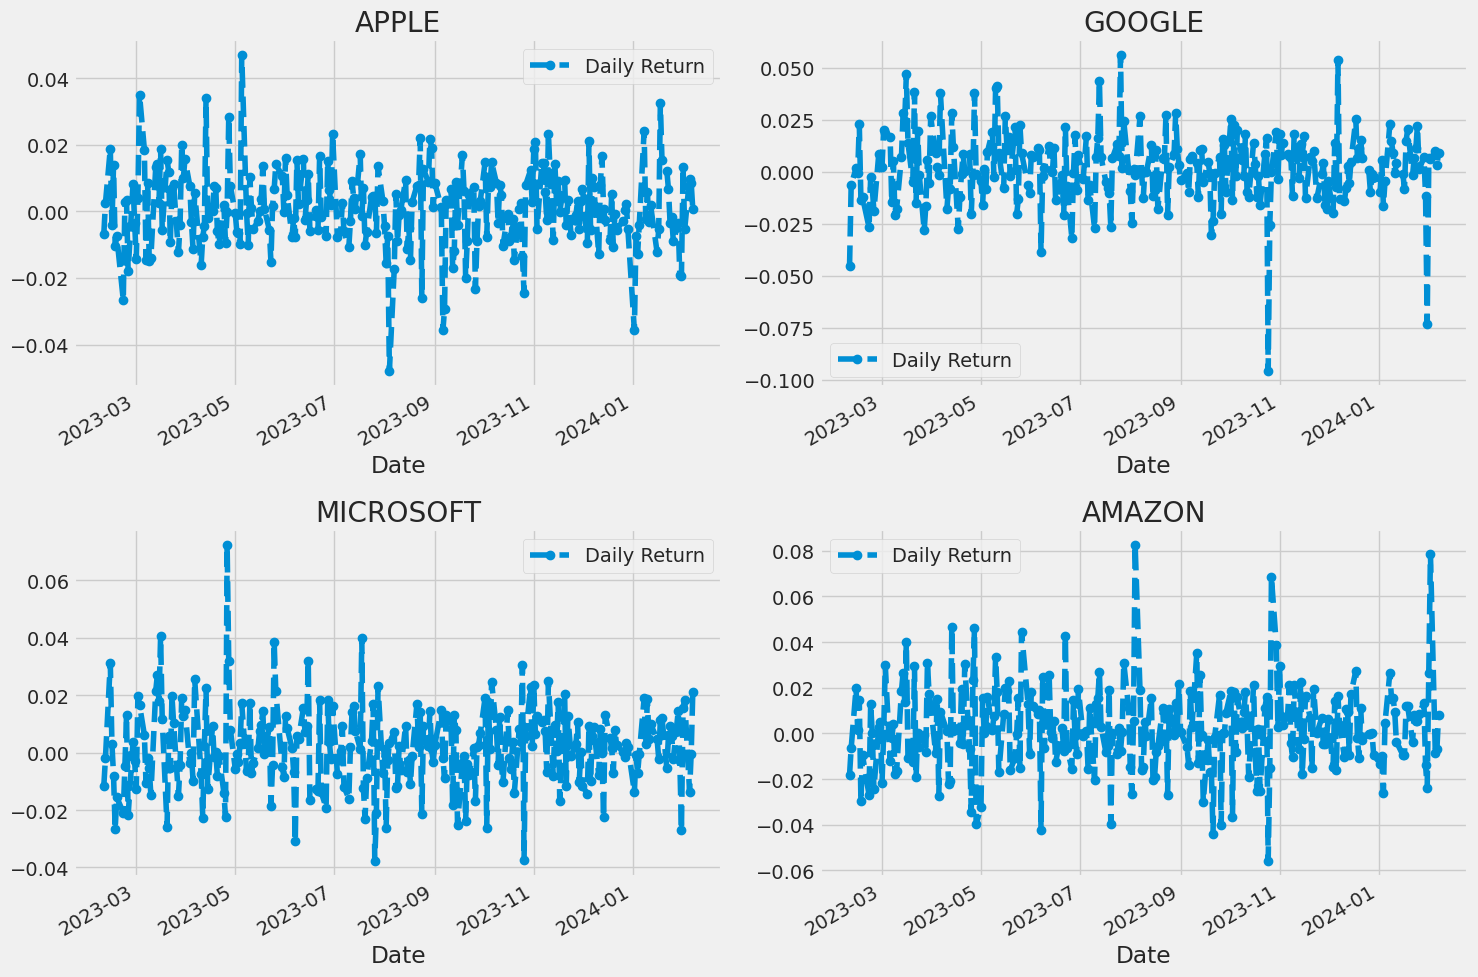

In [10]:
# We'll use pct_change to find the percent change for each day
for company in company_list:
    company['Daily Return'] = company['Adj Close'].pct_change()

# Then we'll plot the daily return percentage
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(10)
fig.set_figwidth(15)

AAPL['Daily Return'].plot(ax=axes[0,0], legend=True, linestyle='--', marker='o')
axes[0,0].set_title('APPLE')

GOOG['Daily Return'].plot(ax=axes[0,1], legend=True, linestyle='--', marker='o')
axes[0,1].set_title('GOOGLE')

MSFT['Daily Return'].plot(ax=axes[1,0], legend=True, linestyle='--', marker='o')
axes[1,0].set_title('MICROSOFT')

AMZN['Daily Return'].plot(ax=axes[1,1], legend=True, linestyle='--', marker='o')
axes[1,1].set_title('AMAZON')

fig.tight_layout()

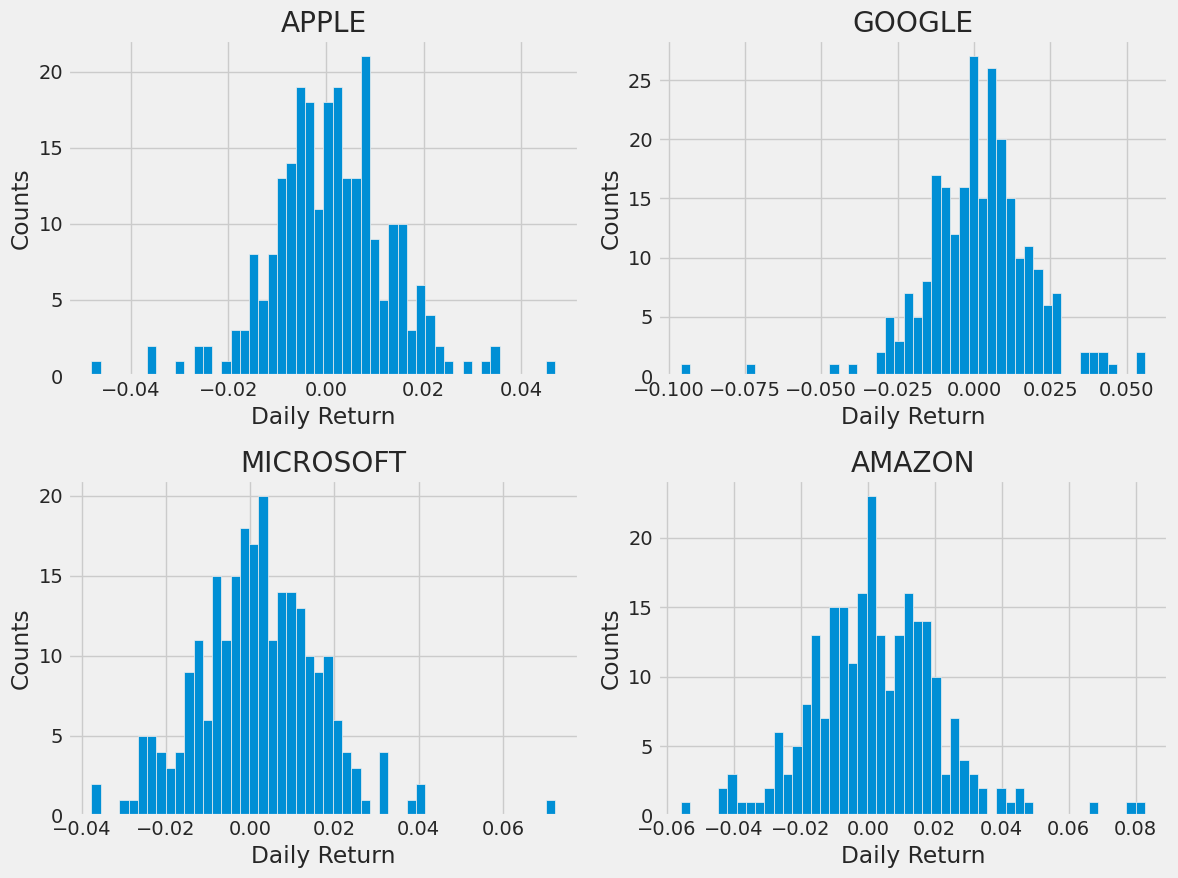

In [11]:
plt.figure(figsize=(12, 9))

for i, company in enumerate(company_list, 1):
    plt.subplot(2, 2, i)
    company['Daily Return'].hist(bins=50)
    plt.xlabel('Daily Return')
    plt.ylabel('Counts')
    plt.title(f'{company_name[i - 1]}')

plt.tight_layout()

In [12]:
# Grab all the closing prices for the tech stock list into one DataFrame

closing_df = pdr.get_data_yahoo(tech_list, start=start, end=end)['Adj Close']

# Make a new tech returns DataFrame
tech_rets = closing_df.pct_change()
tech_rets.head()

[*********************100%%**********************]  4 of 4 completed


Ticker,AAPL,AMZN,GOOG,MSFT
Date,,,,
2023-02-08,NaN,NaN,NaN,NaN
2023-02-09,-0.006912,-0.018091,-0.045400,-0.011660
2023-02-10,0.002456,-0.006413,-0.006285,-0.001972
2023-02-13,0.018807,0.019773,0.001476,0.031243
2023-02-14,-0.004225,0.001607,-0.000526,0.003133


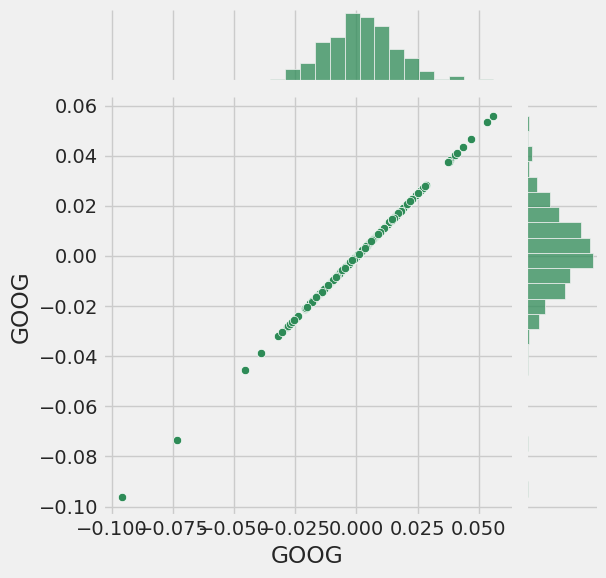

In [13]:
# Comparing Google to itself should show a perfectly linear relationship
sns.jointplot(x='GOOG', y='GOOG', data=tech_rets, kind='scatter', color='seagreen')

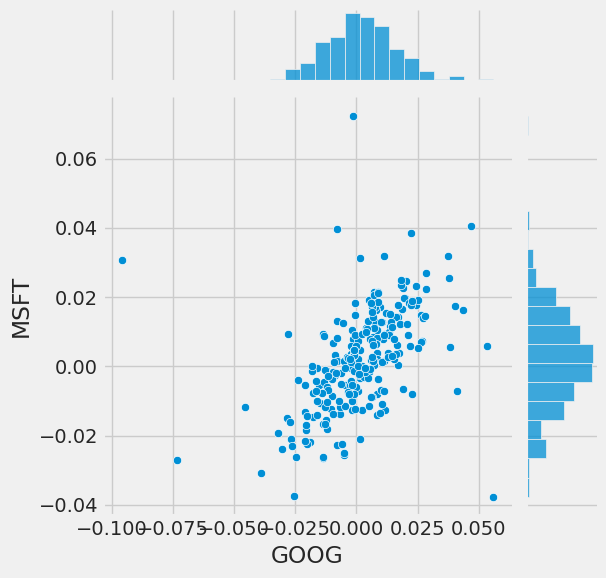

In [14]:
# We'll use joinplot to compare the daily returns of Google and Microsoft
sns.jointplot(x='GOOG', y='MSFT', data=tech_rets, kind='scatter')

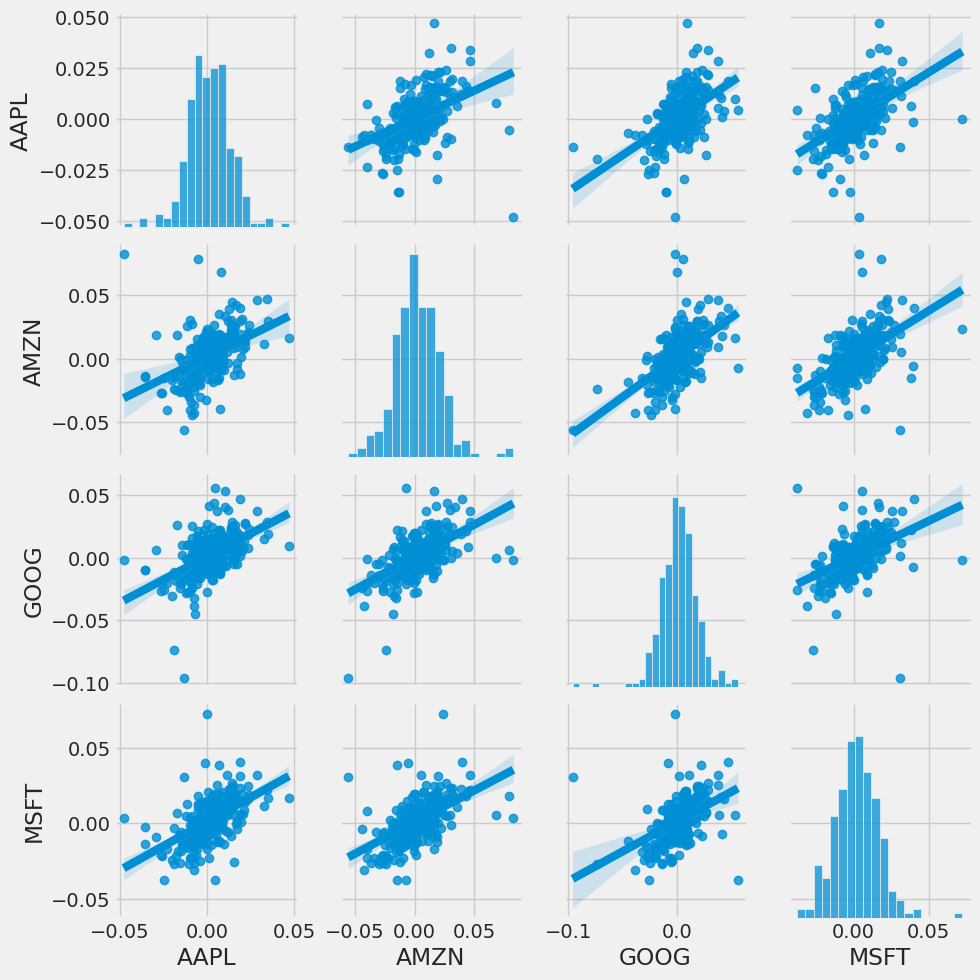

In [15]:
# We can simply call pairplot on our DataFrame for an automatic visual analysis
# of all the comparisons

sns.pairplot(tech_rets, kind='reg')

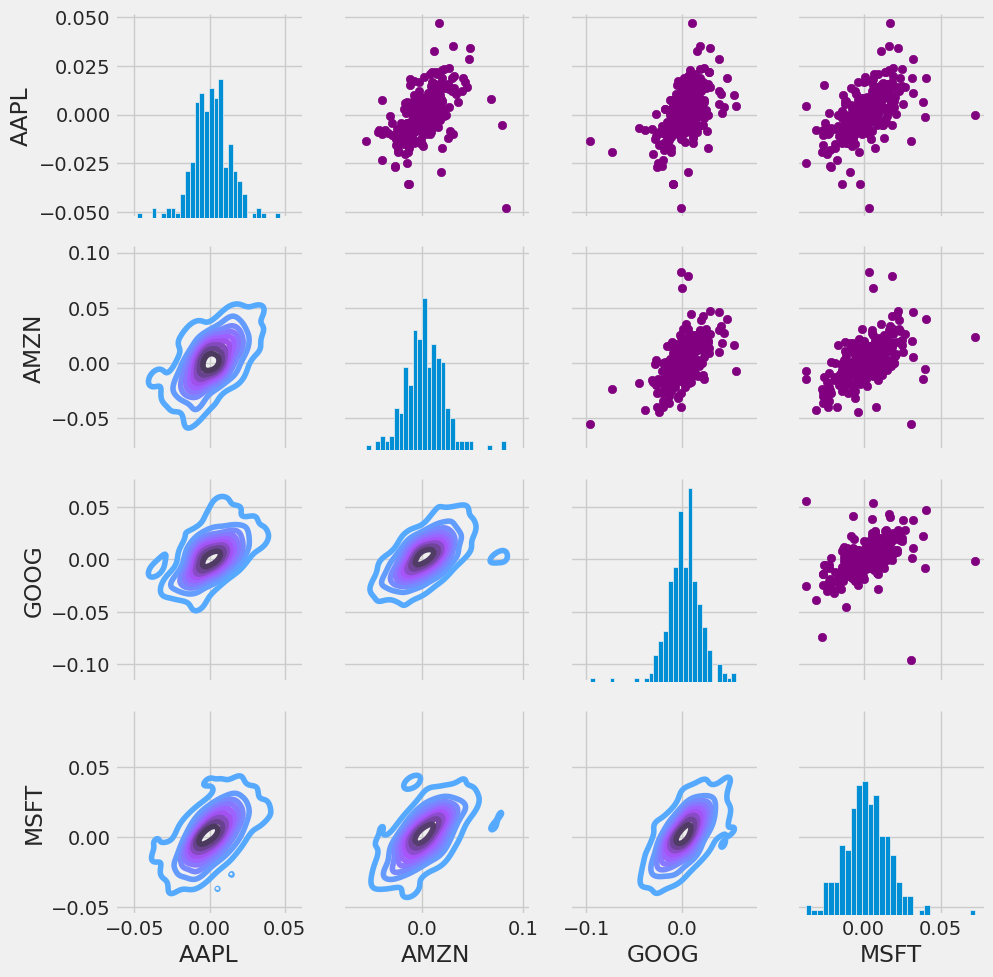

In [16]:
# Set up our figure by naming it returns_fig, call PairPLot on the DataFrame
return_fig = sns.PairGrid(tech_rets.dropna())

# Using map_upper we can specify what the upper triangle will look like.
return_fig.map_upper(plt.scatter, color='purple')

# We can also define the lower triangle in the figure, inclufing the plot type (kde)
# or the color map (BluePurple)
return_fig.map_lower(sns.kdeplot, cmap='cool_d')

# Finally we'll define the diagonal as a series of histogram plots of the daily return
return_fig.map_diag(plt.hist, bins=30)

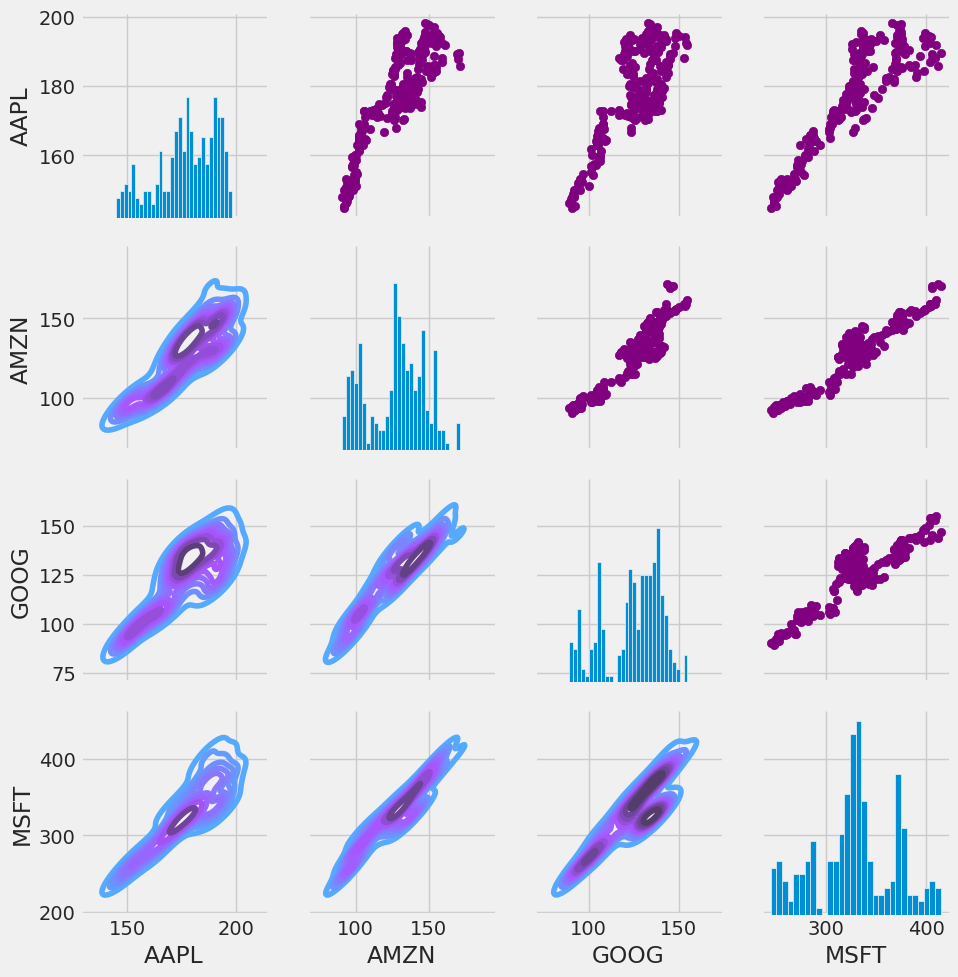

In [17]:
# Set up our figure by naming it returns_fig, call PairPLot on the DataFrame
returns_fig = sns.PairGrid(closing_df)

# Using map_upper we can specify what the upper triangle will look like.
returns_fig.map_upper(plt.scatter,color='purple')

# We can also define the lower triangle in the figure, inclufing the plot type (kde) or the color map (BluePurple)
returns_fig.map_lower(sns.kdeplot,cmap='cool_d')

# Finally we'll define the diagonal as a series of histogram plots of the daily return
returns_fig.map_diag(plt.hist,bins=30)

Text(0.5, 1.0, 'Correlation of stock closing price')

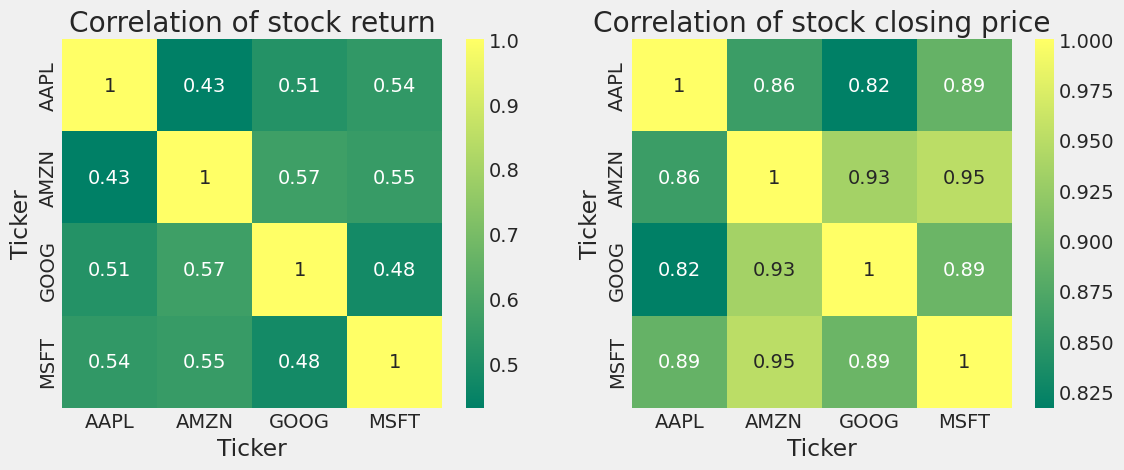

In [18]:
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
sns.heatmap(tech_rets.corr(), annot=True, cmap='summer')
plt.title('Correlation of stock return')

plt.subplot(2, 2, 2)
sns.heatmap(closing_df.corr(), annot=True, cmap='summer')
plt.title('Correlation of stock closing price')

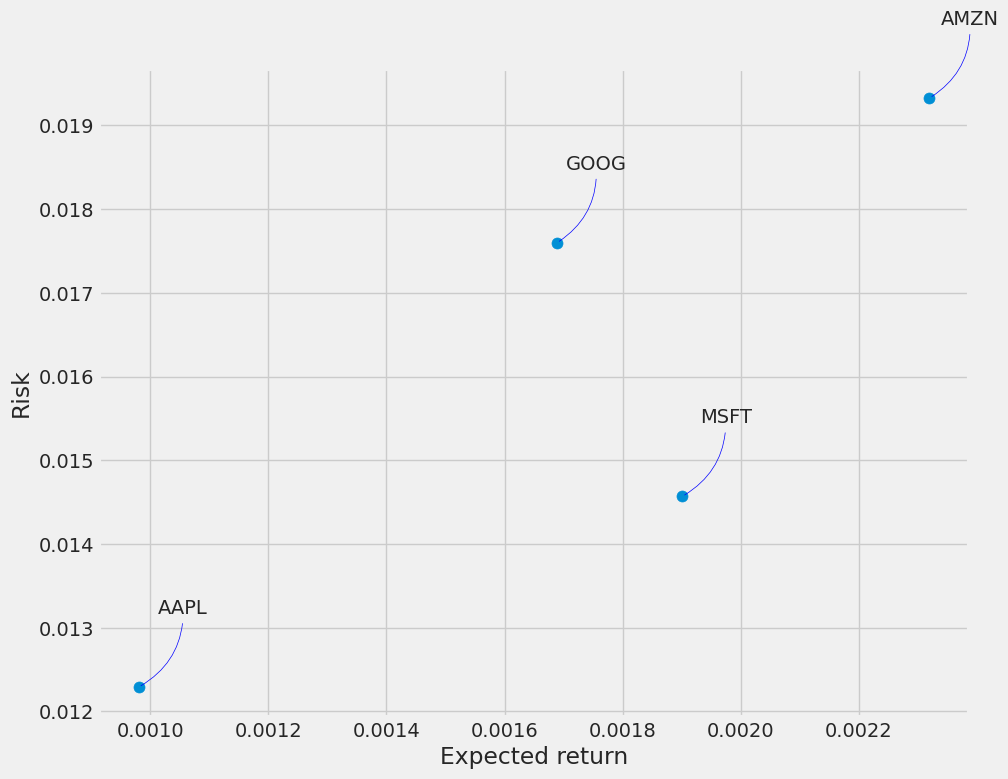

In [19]:
rets = tech_rets.dropna()

area = np.pi * 20

plt.figure(figsize=(10, 8))
plt.scatter(rets.mean(), rets.std(), s=area)
plt.xlabel('Expected return')
plt.ylabel('Risk')

for label, x, y in zip(rets.columns, rets.mean(), rets.std()):
    plt.annotate(label, xy=(x, y), xytext=(50, 50), textcoords='offset points', ha='right', va='bottom',
                 arrowprops=dict(arrowstyle='-', color='blue', connectionstyle='arc3,rad=-0.3'))

In [20]:
# Get the stock quote
df = pdr.get_data_yahoo('AAPL', start='2012-01-01', end=datetime.now())
# Show teh data
df

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,14.621429,14.732143,14.607143,14.686786,12.449689,302220800
2012-01-04,14.642857,14.810000,14.617143,14.765714,12.516598,260022000
2012-01-05,14.819643,14.948214,14.738214,14.929643,12.655557,271269600
2012-01-06,14.991786,15.098214,14.972143,15.085714,12.787855,318292800
2012-01-09,15.196429,15.276786,15.048214,15.061786,12.767573,394024400
...,...,...,...,...,...,...
2024-02-01,183.990005,186.949997,183.820007,186.860001,186.860001,64885400
2024-02-02,179.860001,187.330002,179.250000,185.850006,185.850006,102518000
2024-02-05,188.149994,189.250000,185.839996,187.679993,187.679993,69668800


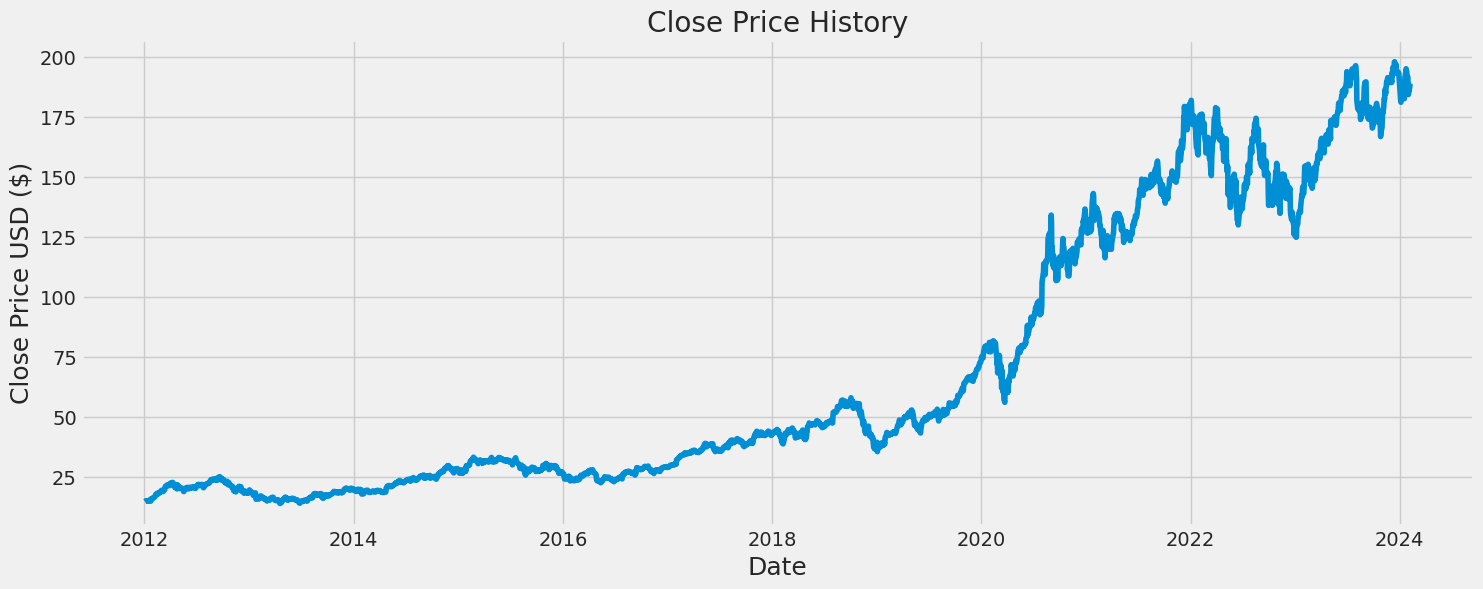

In [21]:
plt.figure(figsize=(16,6))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

In [22]:
# Create a new dataframe with only the 'Close column
data = df.filter(['Close'])
# Convert the dataframe to a numpy array
dataset = data.values
# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .95 ))

training_data_len

2892

In [23]:
# Scale the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.00401431],
       [0.00444289],
       [0.00533302],
       ...,
       [0.94336519],
       [0.95216183],
       [0.95275913]])

In [24]:
# Create the training data set
# Create the scaled training data set
train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()

# Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
# x_train.shape

[array([0.00401431, 0.00444289, 0.00533302, 0.00618049, 0.00605056,
       0.00634339, 0.00620958, 0.00598462, 0.00567821, 0.00662652,
       0.00748175, 0.007218  , 0.00577323, 0.00715207, 0.00579457,
       0.01088518, 0.01049151, 0.01100542, 0.01211663, 0.01278955,
       0.01273332, 0.01252582, 0.01341013, 0.01424207, 0.01518457,
       0.01670691, 0.01990478, 0.01995326, 0.02173353, 0.02306387,
       0.02077746, 0.02165789, 0.02164044, 0.02410915, 0.02375813,
       0.02440779, 0.02557523, 0.0262249 , 0.02809631, 0.02945961,
       0.02985329, 0.02999098, 0.02765997, 0.02709757, 0.02718096,
       0.02937236, 0.02998905, 0.03131358, 0.03443581, 0.03860139,
       0.0378218 , 0.03782373, 0.04083544, 0.04177794, 0.04110694,
       0.04049413, 0.03985611, 0.04197573, 0.0434302 , 0.04403914])]
[0.042534249860459186]

[array([0.00401431, 0.00444289, 0.00533302, 0.00618049, 0.00605056,
       0.00634339, 0.00620958, 0.00598462, 0.00567821, 0.00662652,
       0.00748175, 0.007218  , 0.0

In [25]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

2832/2832 [==============================] - 151s 52ms/step - loss: 0.0012


In [26]:
# Create the testing data set
# Create a new array containing scaled values from index 1543 to 2002
test_data = scaled_data[training_data_len - 60: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

5/5 [==============================] - 2s 28ms/step


11.651964103363799

<ipython-input-27-0cdd5e68a3a9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


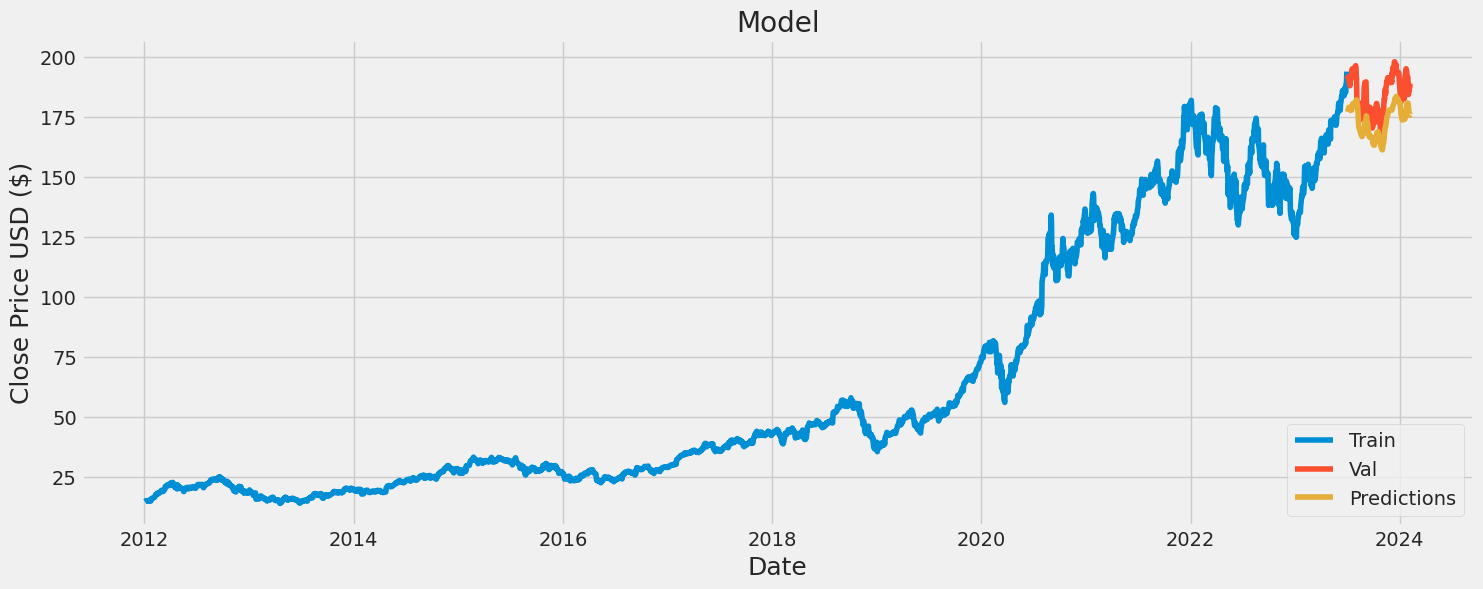

In [27]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [28]:
# Show the valid and predicted prices
valid

,Close,Predictions
Date,,
2023-07-03,192.460007,177.201126
2023-07-05,191.330002,178.187256
2023-07-06,191.809998,178.751160
2023-07-07,190.679993,179.109161
2023-07-10,188.610001,179.137894
...,...,...
2024-02-01,186.860001,178.285553
2024-02-02,185.850006,177.124817
2024-02-05,187.679993,176.168610


In [36]:
accuracy = round(100 - (rmse / valid['Close'].mean()) * 100, 2)
print(f"Prediction accuracy: {accuracy}%")


Prediction accuracy: 93.69%
